In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

import healpy as hp

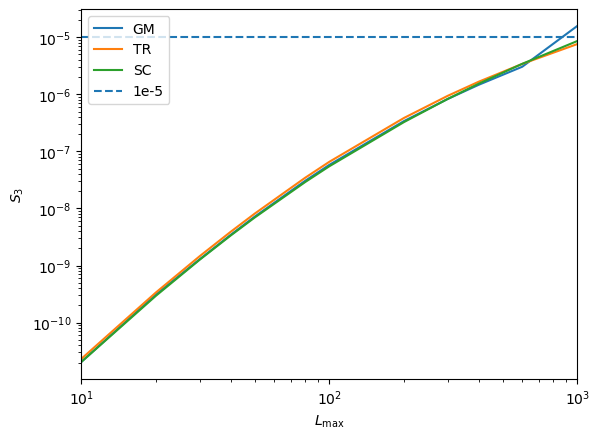

In [18]:
lmaxes_th = [10, 20, 30, 40, 50, 80, 100, 200, 300, 400, 600, 1000]#, 600, 1000]#, 1000, 1100, 2000]

dirnew = "allowed_configs_results"

GM, TR, SC = "GM", "TR", "SC"
cases = [GM, TR, SC]

results = {}

direcs = [dirnew]

for case in cases:
    def read(direc, lmax):
        with open(f"{direc}/{case}_allowed_configs_{lmax}", "rb") as fp:
            results = pickle.load(fp)
        return np.array(results)

    getsum = lambda direc, l: np.sum(read(direc, l))/4/np.pi    

    calculations = [np.array(list(map(lambda l: getsum(d_, l), lmaxes_th))) for d_ in direcs]
    results[case] = calculations


    [plt.loglog(lmaxes_th, calculation, label = case) for calculation, d_ in zip(calculations, direcs)]
plt.hlines(1e-5, 10, 1000, linestyles = "dashed", label = "1e-5")
plt.xlim(10, 1000)
plt.xlabel(r"$L_{\rm{max}}$")
plt.ylabel(r"$S_3$")
plt.legend()

In [3]:
results

{'GM': [array([2.04982495e-11, 3.12147677e-10, 1.28795744e-09, 3.44809028e-09,
         7.17795849e-09, 3.06157346e-08, 5.80377879e-08, 4.52981121e-07,
         1.24879027e-06, 2.45635627e-06, 5.88614925e-06, 1.57884535e-05])],
 'TR': [array([2.31873831e-11, 3.38096284e-10, 1.45590283e-09, 3.89708950e-09,
         8.11235329e-09, 3.46321058e-08, 6.56986858e-08, 3.85360511e-07,
         9.39738337e-07, 1.66049047e-06, 3.41317055e-06, 7.59929881e-06])],
 'SC': [array([2.04869394e-11, 2.95904303e-10, 1.26228722e-09, 3.35402828e-09,
         6.93248480e-09, 2.91071021e-08, 5.48596836e-08, 3.26120124e-07,
         8.28982595e-07, 1.53410503e-06, 3.42639603e-06, 8.58902209e-06])]}

In [4]:
TRcheck = results["TR"][0]

In [5]:
input_map = "/Users/omard/Downloads/SCRATCHFOLDER/giuliosims/map0_kappa_ecp262_dmn2_lmax8000_first.fits"
mappa = hp.read_map(input_map)

In [6]:
#mappa_alm = hp.map2alm(mappa, lmax = 4000)

In [7]:
mappa_alm = hp.read_alm("mappa_alm_lmax_4000.fits")

In [8]:
def arcmin2rad(arcmin):
    return arcmin/60*np.pi/180

In [9]:
#mappa_alm_smoothed = hp.sphtfunc.smoothalm(mappa_alm, fwhm = arcmin2rad(10), pol = False)

In [10]:
#hp.write_alm("mappa_alm_lmax_4000.fits", mappa_alm, overwrite = True)

In [11]:
def filter_alms(alms, lmax):
    Lmax = hp.Alm.getlmax(len(alms))
    ells = np.arange(Lmax+1)
    lowpass = np.zeros_like(ells, dtype = np.float64)
    lowpass[ells <= lmax] = 1.
    lowpass[ells <= 2] = 0.
    return hp.almxfl(alms, lowpass)

def change_lmax_mappa(alms, lmax, nside = 4096):
    new = filter_alms(alms, lmax)
    nside = 1024#(lmax+1)//3
    return hp.alm2map(new, nside = nside, pol = False)

def get_skew_from_map(mappa):
    return np.mean((mappa-np.mean(mappa))**3)


def get_skew_from_lmax(alms, lmax, nside = 4096):
    return get_skew_from_map(change_lmax_mappa(alms, lmax, nside = nside))


lmaxes = [10, 20, 30, 40, 50, 80, 100, 200, 300, 400, 600, 800, 1000, 1100, 2000]
skews = np.array(list(map(lambda l: get_skew_from_lmax(mappa_alm, l), lmaxes)))


In [12]:
lmaxes_th_3 = [10, 20, 30, 40, 50, 80, 100, 200, 300, 400, 600, 800, 1000]#, 600, 800, 1000]#, 1100, 2000]
dirthree = "allowed_configs_results_threej"
dirnew = "allowed_configs_results"
def read(direc, lmax):
    with open(f"{direc}/GM_allowed_configs_{lmax}", "rb") as fp:
        results = pickle.load(fp)
    return np.array(results)

getsum = lambda direc, l: np.sum(read(direc, l))/4/np.pi

calcthree = [np.array(list(map(lambda l: getsum(d_, l), lmaxes_th_3))) for d_ in direcs]

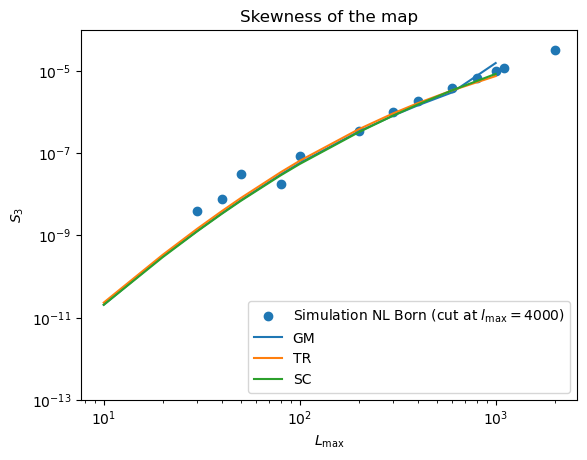

In [19]:
plt.title("Skewness of the map")
plt.scatter(lmaxes, (skews), label = r"Simulation NL Born (cut at $l_{\rm{max}}=4000$)")
for k, calculations in results.items():
    [plt.loglog(lmaxes_th, calculation, label = k) for calculation, d_ in zip(calculations, direcs)]
#plt.hlines(1e-5, 10, 1000, linestyles = "dashed", label = "1e-5")
#plt.hlines(1e-10, 10, 1000, linestyles = "dashed", label = "1e-10")
plt.ylim(1e-13, 1e-4)
plt.xlabel(r"$L_{\rm{max}}$")
plt.ylabel(r"$S_3$")
plt.legend()
plt.savefig("figures/skewness.png", dpi = 300)
